In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import sys
import random
import wandb
import torch.nn.functional as F
from torch.utils.data import TensorDataset
from tqdm import tqdm



In [2]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
device

device(type='cuda')

In [3]:
import os

os.environ["WANDB_NOTEBOOK_NAME"] = '/home/agcl/Downloads/CS6910_ASSIGNMENT_3-ATTENTION -model2- ATTENTION HEATMAP.ipynb'

In [4]:
wandb.login()

wandb: Currently logged in as: ananthu2014. Use `wandb login --relogin` to force relogin


True

In [5]:
'''function to load the data'''
def load_data(path,language_names):
    df=pd.read_csv(path,header=None)
    df.columns=language_names
    return df

In [6]:
'''Here,basically,the input is given to the encoder in English language and is transliterated to Hindi
by the decoder'''
path_train="/home/agcl/Downloads/hin_train.csv"
language_names = ['English','transliteration_in_hindi']
df_train=load_data(path_train,language_names)
print(df_train.shape)
df_train

(51200, 2)


,English,transliteration_in_hindi
0,shastragaar,शस्त्रागार
1,bindhya,बिन्द्या
2,kirankant,किरणकांत
3,yagyopaveet,यज्ञोपवीत
4,ratania,रटानिया
...,...,...
51195,toned,टोंड
51196,mutanaazaa,मुतनाज़ा
51197,asahmaton,असहमतों
51198,sulgaayin,सुलगायीं


In [7]:
#path_test="C:/Users/anant/Downloads/hin_test.csv"
path_test="/home/agcl/Downloads/hin_test.csv"
#path_validation="C:/Users/anant/Downloads/hin_valid.csv"
path_validation="/home/agcl/Downloads/hin_valid.csv"
df_validation=load_data(path_validation,language_names)
print(df_validation.shape)
df_test=load_data(path_test,language_names)
print(df_test.shape)

(4096, 2)
(4096, 2)


In [8]:
'''Function for acquiring all the characters of the given data'''
def split_words(x):
    x=np.array(x)
    alpha=['_','\t','\n',' '] #pad token, start of word, end of word and unknown tokens
    b=[]
    for i in range(x.shape[0]):
        a=list(x[i])
        for j in range(len(a)):
            if a[j] not in b:
                b.append(a[j])
    b=sorted(b)
    alpha=alpha+b
    return alpha

In [9]:
'''All the english characters are stored into the list english_vocab and all the hindi characters are
stored into the list hindi_vocab'''
english_vocab=split_words(df_train['English'])
hindi_vocab=split_words(df_train['transliteration_in_hindi'])

In [10]:
print(len(english_vocab))
print(len(hindi_vocab))
print(english_vocab)
print(hindi_vocab)

30
68
['_', '\t', '\n', ' ', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']
['_', '\t', '\n', ' ', 'ँ', 'ं', 'ः', 'अ', 'आ', 'इ', 'ई', 'उ', 'ऊ', 'ऋ', 'ए', 'ऐ', 'ऑ', 'ओ', 'औ', 'क', 'ख', 'ग', 'घ', 'ङ', 'च', 'छ', 'ज', 'झ', 'ञ', 'ट', 'ठ', 'ड', 'ढ', 'ण', 'त', 'थ', 'द', 'ध', 'न', 'प', 'फ', 'ब', 'भ', 'म', 'य', 'र', 'ल', 'ळ', 'व', 'श', 'ष', 'स', 'ह', '़', 'ऽ', 'ा', 'ि', 'ी', 'ु', 'ू', 'ृ', 'ॅ', 'े', 'ै', 'ॉ', 'ो', 'ौ', '्']


In [11]:
'''Functions to create the vocabulary dictionaries with their indices'''
def int_to_char(vocab):
    int2char={} #padding token, start of word, end of word token and unknown token
    for i in range(len(vocab)):
        int2char[i]=vocab[i][0]
    return int2char

In [12]:
int2char_eng=int_to_char(english_vocab)
print(int2char_eng)

{0: '_', 1: '\t', 2: '\n', 3: ' ', 4: 'a', 5: 'b', 6: 'c', 7: 'd', 8: 'e', 9: 'f', 10: 'g', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'l', 16: 'm', 17: 'n', 18: 'o', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 't', 24: 'u', 25: 'v', 26: 'w', 27: 'x', 28: 'y', 29: 'z'}


In [13]:
def char_to_int(int2char):
    char2int={ch:ii for ii,ch in int2char.items()}
    return char2int

In [14]:
char2int_eng=char_to_int(int2char_eng)
print(char2int_eng)

{'_': 0, '\t': 1, '\n': 2, ' ': 3, 'a': 4, 'b': 5, 'c': 6, 'd': 7, 'e': 8, 'f': 9, 'g': 10, 'h': 11, 'i': 12, 'j': 13, 'k': 14, 'l': 15, 'm': 16, 'n': 17, 'o': 18, 'p': 19, 'q': 20, 'r': 21, 's': 22, 't': 23, 'u': 24, 'v': 25, 'w': 26, 'x': 27, 'y': 28, 'z': 29}


In [15]:
int2char_hin=int_to_char(hindi_vocab)
print(int2char_hin)

{0: '_', 1: '\t', 2: '\n', 3: ' ', 4: 'ँ', 5: 'ं', 6: 'ः', 7: 'अ', 8: 'आ', 9: 'इ', 10: 'ई', 11: 'उ', 12: 'ऊ', 13: 'ऋ', 14: 'ए', 15: 'ऐ', 16: 'ऑ', 17: 'ओ', 18: 'औ', 19: 'क', 20: 'ख', 21: 'ग', 22: 'घ', 23: 'ङ', 24: 'च', 25: 'छ', 26: 'ज', 27: 'झ', 28: 'ञ', 29: 'ट', 30: 'ठ', 31: 'ड', 32: 'ढ', 33: 'ण', 34: 'त', 35: 'थ', 36: 'द', 37: 'ध', 38: 'न', 39: 'प', 40: 'फ', 41: 'ब', 42: 'भ', 43: 'म', 44: 'य', 45: 'र', 46: 'ल', 47: 'ळ', 48: 'व', 49: 'श', 50: 'ष', 51: 'स', 52: 'ह', 53: '़', 54: 'ऽ', 55: 'ा', 56: 'ि', 57: 'ी', 58: 'ु', 59: 'ू', 60: 'ृ', 61: 'ॅ', 62: 'े', 63: 'ै', 64: 'ॉ', 65: 'ो', 66: 'ौ', 67: '्'}


In [16]:
char2int_hin=char_to_int(int2char_hin)
print(char2int_hin)

{'_': 0, '\t': 1, '\n': 2, ' ': 3, 'ँ': 4, 'ं': 5, 'ः': 6, 'अ': 7, 'आ': 8, 'इ': 9, 'ई': 10, 'उ': 11, 'ऊ': 12, 'ऋ': 13, 'ए': 14, 'ऐ': 15, 'ऑ': 16, 'ओ': 17, 'औ': 18, 'क': 19, 'ख': 20, 'ग': 21, 'घ': 22, 'ङ': 23, 'च': 24, 'छ': 25, 'ज': 26, 'झ': 27, 'ञ': 28, 'ट': 29, 'ठ': 30, 'ड': 31, 'ढ': 32, 'ण': 33, 'त': 34, 'थ': 35, 'द': 36, 'ध': 37, 'न': 38, 'प': 39, 'फ': 40, 'ब': 41, 'भ': 42, 'म': 43, 'य': 44, 'र': 45, 'ल': 46, 'ळ': 47, 'व': 48, 'श': 49, 'ष': 50, 'स': 51, 'ह': 52, '़': 53, 'ऽ': 54, 'ा': 55, 'ि': 56, 'ी': 57, 'ु': 58, 'ू': 59, 'ृ': 60, 'ॅ': 61, 'े': 62, 'ै': 63, 'ॉ': 64, 'ो': 65, 'ौ': 66, '्': 67}


In [17]:
'''Finding the maximum sequence length'''
length_eng=[len(i) for i in df_train['English']]
length_hin=[len(i) for i in df_train['transliteration_in_hindi']]

In [18]:
length_eng_max=max(length_eng)+2 #we have to account for the start and end token
print(f'The maximum sequence length of English words is {length_eng_max}')
length_hin_max=max(length_hin)+2
print(f'The maximum sequence length of transliterated words is {length_hin_max}')

The maximum sequence length of English words is 26
The maximum sequence length of transliterated words is 22


In [19]:
num_english_tokens=len(english_vocab)
print(num_english_tokens)

30


In [20]:
num_hindi_tokens=len(hindi_vocab)
print(num_hindi_tokens)

68


In [21]:
print(length_eng_max)
print(length_hin_max)

26
22


In [22]:
print(int2char_eng)
'''The position of padding is zero itself, so we can create tensors using torch.zeros and proceed'''

{0: '_', 1: '\t', 2: '\n', 3: ' ', 4: 'a', 5: 'b', 6: 'c', 7: 'd', 8: 'e', 9: 'f', 10: 'g', 11: 'h', 12: 'i', 13: 'j', 14: 'k', 15: 'l', 16: 'm', 17: 'n', 18: 'o', 19: 'p', 20: 'q', 21: 'r', 22: 's', 23: 't', 24: 'u', 25: 'v', 26: 'w', 27: 'x', 28: 'y', 29: 'z'}


'The position of padding is zero itself, so we can create tensors using torch.zeros and proceed'

In [23]:
def process_data(df,english_vocab=english_vocab,hindi_vocab=hindi_vocab,
                 length_eng_max=length_eng_max,length_hin_max=length_hin_max,char2int_eng=char2int_eng
                 ,char2int_hin=char2int_hin):
    
    '''removing words of length more than max length'''
    df['English'] = df['English'].str.lower()
    df['transliteration_in_hindi'] = df['transliteration_in_hindi'].str.lower()
    df = df[df['English'].apply(len) <= length_eng_max-2]
    df = df[df['transliteration_in_hindi'].apply(len) <= length_hin_max-2]
    '''Adding start and end of word tokens'''
    y_og = df['transliteration_in_hindi'].values
    x_og = df['English'].values
    x = '\t'+x_og+'\n'
    y = '\t'+y_og+'\n'
    y_do=y_og+'\n'
    unknown=3
    pad=0
    pad_char='_'
    unknown_char=' '
    start=1
    end=2
    
    enc_input_data=torch.zeros(len(x),length_eng_max)
    dec_input_data=torch.zeros(len(y),length_hin_max)
    dec_output_data=torch.zeros(len(y),length_hin_max)
    for i, (xx,yy) in enumerate(zip(x,y)):
        for j,char in enumerate(xx):
            enc_input_data[i,j]=char2int_eng[char]
        #pad character is zero so no need of assigning it again
        for j,char in enumerate(yy):
            if char in hindi_vocab:
                dec_input_data[i,j]=char2int_hin[char]
            else:
                dec_input_data[i,j]=char2int_hin[unknown_char]
    
    for i, (xx,yy) in enumerate(zip(x,y_do)):
        for j,char in enumerate(yy):
            if char in hindi_vocab:
                dec_output_data[i,j]=char2int_hin[char]
            else:
                dec_input_data[i,j]=char2int_hin[unknown_char]
                
    return enc_input_data,dec_input_data,dec_output_data

In [24]:
def one_hot_encoding(df,english_vocab=english_vocab,hindi_vocab=hindi_vocab,
                 length_eng_max=length_eng_max,length_hin_max=length_hin_max,char2int_eng=char2int_eng
                 ,char2int_hin=char2int_hin):
    
    
    '''removing words of length more than max length'''
    df = df[df['English'].apply(len) <= length_eng_max-2]
    df = df[df['transliteration_in_hindi'].apply(len) <= length_hin_max-2]
    '''Adding start and end of word tokens'''
    y = df['transliteration_in_hindi'].values
    x= df['English'].values
    x = '\t'+x+'\n'
    y = '\t'+y+'\n'
    
    unknown=3
    pad=0
    pad_char='_'
    unknown_char=' '
    start=1
    end=2
    
    encoder_input_data = np.zeros(
    (len(df['English']), length_eng_max, num_english_tokens), dtype="float32")
    decoder_input_data = np.zeros(
    (len(df['transliteration_in_hindi']), length_hin_max, num_hindi_tokens), dtype="float32")
    decoder_output_data = np.zeros(
    (len(df['transliteration_in_hindi']), length_hin_max, num_hindi_tokens), dtype="float32")
    pad_char='_'
    for i , (input_text,target_text) in enumerate(zip(x,y)):
        for t,char in enumerate(input_text):
            encoder_input_data[i,t,char2int_eng[char]]=1
        encoder_input_data[i,t+1:,char2int_eng[pad_char]]=1
    
        for t,char in enumerate(target_text):
            if char in hindi_vocab:
                decoder_input_data[i,t,char2int_hin[char]]=1
            else:
                decoder_input_data[i,t,char2int_hin[unknown_char]]=1
        decoder_input_data[i,t+1:,char2int_hin[pad_char]]=1
    
        '''decoder target data is one step ahead of decoder input data by one timestep
        and doesnot includes start token'''
        for t,char in enumerate(target_text):
            if t>0:
                if char in hindi_vocab:
                    decoder_output_data[i,t-1,char2int_hin[char]]=1
                else:
                    decoder_output_data[i,t-1,char2int_hin[unknown_char]]=1
                
        decoder_output_data[i,t:,char2int_hin[pad_char]]=1
    
    return torch.tensor(encoder_input_data),torch.tensor(decoder_input_data),torch.tensor(decoder_output_data)
    
    

In [25]:
enc_input_data,dec_input_data,dec_output_data=process_data(df_train)

In [26]:
encoder_input_data,decoder_input_data,decoder_output_data=one_hot_encoding(df_train)

In [27]:
print(enc_input_data.shape)
print(dec_input_data.shape)

torch.Size([51200, 26])
torch.Size([51200, 22])


In [28]:
print(encoder_input_data.shape)
print(decoder_input_data.shape)
print(decoder_output_data.shape)

torch.Size([51200, 26, 30])
torch.Size([51200, 22, 68])
torch.Size([51200, 22, 68])


In [29]:
print(dec_input_data[0])

tensor([ 1., 49., 51., 67., 34., 67., 45., 55., 21., 55., 45.,  2.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])


In [30]:
print(dec_output_data[0])

tensor([49., 51., 67., 34., 67., 45., 55., 21., 55., 45.,  2.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])


In [31]:
enc_input_data_test,dec_input_data_test,dec_output_data_test=process_data(df_test)

In [32]:
print(enc_input_data_test.shape)
print(dec_input_data_test.shape)

torch.Size([4095, 26])
torch.Size([4095, 22])


In [33]:
enc_input_data_val,dec_input_data_val,dec_output_data_val=process_data(df_validation)

In [34]:
print(enc_input_data_val.shape)
print(dec_input_data_val.shape)

torch.Size([4096, 26])
torch.Size([4096, 22])


In [35]:
encoder_input_data_test,decoder_input_data_test,decoder_output_data_test=one_hot_encoding(df_test)

In [36]:
print(encoder_input_data_test.shape)
print(decoder_input_data_test.shape)
print(decoder_output_data_test.shape)

torch.Size([4095, 26, 30])
torch.Size([4095, 22, 68])
torch.Size([4095, 22, 68])


In [37]:
encoder_input_data_val,decoder_input_data_val,decoder_output_data_val=one_hot_encoding(df_validation)

In [38]:
print(encoder_input_data_val.shape)
print(decoder_input_data_val.shape)
print(decoder_output_data_val.shape)

torch.Size([4096, 26, 30])
torch.Size([4096, 22, 68])
torch.Size([4096, 22, 68])


In [39]:
print(torch.argmax(decoder_input_data,dim=-1))

tensor([[ 1, 49, 51,  ...,  0,  0,  0],
        [ 1, 41, 56,  ...,  0,  0,  0],
        [ 1, 19, 56,  ...,  0,  0,  0],
        ...,
        [ 1,  7, 51,  ...,  0,  0,  0],
        [ 1, 51, 58,  ...,  0,  0,  0],
        [ 1,  7,  5,  ...,  0,  0,  0]])


In [40]:
print(dec_input_data)

tensor([[ 1., 49., 51.,  ...,  0.,  0.,  0.],
        [ 1., 41., 56.,  ...,  0.,  0.,  0.],
        [ 1., 19., 56.,  ...,  0.,  0.,  0.],
        ...,
        [ 1.,  7., 51.,  ...,  0.,  0.,  0.],
        [ 1., 51., 58.,  ...,  0.,  0.,  0.],
        [ 1.,  7.,  5.,  ...,  0.,  0.,  0.]])


In [41]:
print(torch.argmax(decoder_output_data,dim=-1))

tensor([[49, 51, 67,  ...,  0,  0,  0],
        [41, 56, 38,  ...,  0,  0,  0],
        [19, 56, 45,  ...,  0,  0,  0],
        ...,
        [ 7, 51, 52,  ...,  0,  0,  0],
        [51, 58, 46,  ...,  0,  0,  0],
        [ 7,  5, 24,  ...,  0,  0,  0]])


In [42]:
print(dec_output_data)

tensor([[49., 51., 67.,  ...,  0.,  0.,  0.],
        [41., 56., 38.,  ...,  0.,  0.,  0.],
        [19., 56., 45.,  ...,  0.,  0.,  0.],
        ...,
        [ 7., 51., 52.,  ...,  0.,  0.,  0.],
        [51., 58., 46.,  ...,  0.,  0.,  0.],
        [ 7.,  5., 24.,  ...,  0.,  0.,  0.]])


In [43]:
df_train['transliteration_in_hindi']='\t'+df_train['transliteration_in_hindi']+'\n'
df_train['English']='\t'+df_train['English']+'\n'

In [44]:
df_train['English_seq'] = df_train['English'].apply(lambda x: [char2int_eng[char] for char in x])
df_train['transliteration_seq'] = df_train['transliteration_in_hindi'].apply(lambda x: [char2int_hin[char] for char in x])


In [45]:
df_train

,English,transliteration_in_hindi,English_seq,transliteration_seq
0,\tshastragaar\n,\tशस्त्रागार\n,"[1, 22, 11, 4, 22, 23, 21, 4, 10, 4, 4, 21, 2]","[1, 49, 51, 67, 34, 67, 45, 55, 21, 55, 45, 2]"
1,\tbindhya\n,\tबिन्द्या\n,"[1, 5, 12, 17, 7, 11, 28, 4, 2]","[1, 41, 56, 38, 67, 36, 67, 44, 55, 2]"
2,\tkirankant\n,\tकिरणकांत\n,"[1, 14, 12, 21, 4, 17, 14, 4, 17, 23, 2]","[1, 19, 56, 45, 33, 19, 55, 5, 34, 2]"
3,\tyagyopaveet\n,\tयज्ञोपवीत\n,"[1, 28, 4, 10, 28, 18, 19, 4, 25, 8, 8, 23, 2]","[1, 44, 26, 67, 28, 65, 39, 48, 57, 34, 2]"
4,\tratania\n,\tरटानिया\n,"[1, 21, 4, 23, 4, 17, 12, 4, 2]","[1, 45, 29, 55, 38, 56, 44, 55, 2]"
...,...,...,...,...
51195,\ttoned\n,\tटोंड\n,"[1, 23, 18, 17, 8, 7, 2]","[1, 29, 65, 5, 31, 2]"
51196,\tmutanaazaa\n,\tमुतनाज़ा\n,"[1, 16, 24, 23, 4, 17, 4, 4, 29, 4, 4, 2]","[1, 43, 58, 34, 38, 55, 26, 53, 55, 2]"
51197,\tasahmaton\n,\tअसहमतों\n,"[1, 4, 22, 4, 11, 16, 4, 23, 18, 17, 2]","[1, 7, 51, 52, 43, 34, 65, 5, 2]"
51198,\tsulgaayin\n,\tसुलगायीं\n,"[1, 22, 24, 15, 10, 4, 4, 28, 12, 17, 2]","[1, 51, 58, 46, 21, 55, 44, 57, 5, 2]"


In [46]:
enc_input_data=enc_input_data.long()
dec_input_data=dec_input_data.long()
enc_input_data_test=enc_input_data_test.long()
dec_input_data_test=dec_input_data_test.long()
enc_input_data_val=enc_input_data_val.long()
dec_input_data_val=dec_input_data_val.long()
encoder_input_data=encoder_input_data.long()
decoder_input_data=decoder_input_data.long()
decoder_output_data=decoder_output_data.long()

In [47]:
# def calculate_word_accuracy(dec_predicted_data, dec_output_data):
#     #Here, we have to pass the arguments in the shape(batch_size,sequence_length)
#     batch_size = dec_predicted_data.shape[0]
#     dec_predicted_data=torch.argmax(dec_predicted_data,dim=-1)
#     dec_output_data=torch.argmax(dec_output_data,dim=-1)
#     with torch.no_grad():
#         true_words = 0
#         for i in range(batch_size):
#             mark = True
#             for j in range(dec_predicted_data.shape[1]):
#                 if dec_predicted_data[i, j] == dec_output_data[i, j]:
#                     mark = True
#                 else:
#                     mark = False
#                     break
#             if mark == True:
#                 true_words =true_words+ 1
#     return (true_words / batch_size)*100


In [48]:
def calculate_word_accuracy(dec_predicted_data, dec_output_data):
    # Here, we have to pass the arguments in the shape (batch_size, sequence_length)
    dec_predicted_data = torch.argmax(dec_predicted_data, dim=-1)
    dec_output_data = torch.argmax(dec_output_data, dim=-1)
    
    with torch.no_grad():
        match = (dec_predicted_data == dec_output_data).all(dim=1)
        true_words = match.sum().item()
        batch_size = dec_predicted_data.shape[0]
    
    accuracy = (true_words / batch_size) * 100
    return accuracy


In [49]:
word_acc=calculate_word_accuracy(decoder_input_data,decoder_output_data)

In [50]:
print(word_acc)

0.0


In [51]:
def calculate_char_accuracy(decoder_predicted_data, decoder_output_data):
    #Here, we have to pass the arguments in the shape(batch_size,sequence_length,unique_tokens)
    batch_size, seq_length,unique_tokens = decoder_predicted_data.shape
    dec_predicted_data=torch.argmax(decoder_predicted_data,dim=-1)
    dec_output_data=torch.argmax(decoder_output_data,dim=-1)
    
    with torch.no_grad():
        correct_count = (dec_predicted_data == dec_output_data).sum().item()
        return (correct_count / (seq_length * batch_size))*100


In [52]:
char_accuracy = calculate_char_accuracy(decoder_input_data[7:9,:,:],decoder_input_data[1:3,:,:])

In [53]:
print(char_accuracy)

61.36363636363637


In [54]:
unique_tokens_eng=len(english_vocab)
unique_tokens_hin=len(hindi_vocab)

In [55]:
def data_loader(x,y,z,batch_size,device=device):
    
    x=x.to(device)
    y=y.to(device)
    z=z.to(device)
    combined=TensorDataset(x,y,z)
    loader=DataLoader(combined,batch_size=batch_size,shuffle=False,drop_last=True)#required in test data
    return loader

In [56]:
import time
import math


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [57]:
class Encoder(nn.Module):
    def __init__(self, embed_dim, hidden_dim, layer_dim, drop_out, bi_dir, cell,unique_tokens_eng):
        '''unique_token_hin is the third dimension in one hot encoding or no of tokens in eng or input size'''
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.cell = cell
        self.bi_dir = bi_dir
        self.unique_tokens_eng=unique_tokens_eng
        self.embed_dim=embed_dim
        self.drop_out=drop_out
        '''The input to the encoder will be of shape (batch_size,sequence_length) and the output size will be
        (batch_size,seq_length,embed_size)'''
        self.dropout=nn.Dropout(p=self.drop_out)

        self.embedding = nn.Embedding(unique_tokens_eng, embed_dim, padding_idx=0) 
        
        self.rnn=nn.RNN(embed_dim,hidden_dim,dropout=self.drop_out,
                        num_layers=layer_dim,bidirectional=bi_dir,batch_first=True)
        self.gru=nn.GRU(embed_dim,hidden_dim,dropout=self.drop_out,
                        num_layers=layer_dim,bidirectional=bi_dir,batch_first=True)
        self.lstm=nn.LSTM(embed_dim,hidden_dim,dropout=self.drop_out,
                         num_layers=layer_dim,bidirectional=bi_dir,batch_first=True)

    def forward(self, x,hidden):
        '''Here, x is the encoder input data'''
        batch_size=x.size(0)
        x=x.to(device)
        embedding_input = self.embedding(x.long())
        embedding_input = self.dropout(embedding_input)
        #print(embedding_input.shape)
#         if self.cell == "LSTM":
#             h_0 =torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim, device=device)
#             c_0=torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim, device=device)  
#         else:
#             h_0=torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim, device=device)
              
        if self.cell=="GRU":
            output,h_n=self.gru(embedding_input,hidden)#h_0.detach())
            #print(output.shape)
            #print(h_n.shape)
            return output,h_n
        elif self.cell=='RNN':
            output,h_n=self.gru(embedding_input,hidden)#.detach())
            #print(output.shape)
            #print(h_n.shape)
            return output,h_n
        elif self.cell=='LSTM':
            output,(h_n,c_n)=self.lstm(embedding_input,hidden)
            #(h_0.detach(),c_0.detach()))
            #print(output.shape)
            #print(h_n.shape)
            #print(c_n.shape)
            return output,(h_n,c_n)
            
    def encoder_initial(self,batch_size,device=device):
        if self.cell == "LSTM":
            h_0 =torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim, device=device)
            c_0 =torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim, device=device) 
            return (h_0,c_0)
        #H_0,C_0 HAVE SAME DIMENSION
        else:
            h_0=torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim, device=device)
            return h_0

In [58]:
# class Decoder_attention(nn.Module):
#     def __init__(self, embed_dim, hidden_dim, layer_dim, drop_out, bi_dir, cell,
#                  unique_tokens_hin, input_length,target_length):
#         '''unique_token_hin is the third dimension in one hot encoding or no of tokens in hindi or output size'''
#         #input_length is the sequence length of encoder input(english)
#         super(Decoder_attention, self).__init__()
#         self.hidden_dim = hidden_dim
#         self.layer_dim = layer_dim
#         self.cell = cell
#         self.bi_dir = bi_dir
#         self.unique_tokens_hin = unique_tokens_hin
#         self.embed_dim = embed_dim
#         self.drop_out = drop_out
#         self.input_length = input_length
#         self.target_length=target_length
        
#         self.embedding = nn.Embedding(unique_tokens_hin, embed_dim, padding_idx=0)
#         self.dropout = nn.Dropout(p=self.drop_out)
#         self.UattnSt_1 = nn.Linear(hidden_dim*(int(self.bi_dir)+1),hidden_dim*(int(self.bi_dir)+1)) #St-1 is of shape (num_layers(1+D),batch_size,hidden_dim),which should be 
#         #converted into (batch_size,1,hidden_dim). So ,either reshape it accordingly or take it from decoder rnn
#         #output; not after softmax.output after this:(batch_size,1,hidden_dim)
#         self.Wattnh_j = nn.Linear(hidden_dim*(int(self.bi_dir)+1),hidden_dim*(int(self.bi_dir)+1))#h_j contains all the encoder hidden states,taken from encoder outputs, which is 
#         #of shape(batch_size,input_tokens,hidden_dim).output(batch_size,input_tokens,hidden_dim)
#         self.tanh = nn.Tanh()
#         self.e_jt = nn.Linear(hidden_dim*(int(self.bi_dir)+1),1)#Vattn.T process is performed.Output gives attention score of shape
#         #(batch_size,input_tokens,1).
#         self.alpha_jt=nn.Softmax(dim=-1)
#         self.rnn = nn.RNN(self.embed_dim + hidden_dim*(int(self.bi_dir)+1) , hidden_dim,
#                     num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
#         self.gru = nn.GRU(self.embed_dim + hidden_dim*(int(self.bi_dir)+1) , hidden_dim,
#                     num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
#         self.lstm = nn.LSTM(self.embed_dim + hidden_dim*(int(self.bi_dir)+1), hidden_dim,
#                     num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
#         self.relu = nn.ReLU()
#         self.out_put = nn.Linear((1 + int(self.bi_dir)) * self.hidden_dim, self.unique_tokens_hin)
#         self.softmax = nn.LogSoftmax(dim=-1)



#     def forward(self, x, hidden, encoder_outputs):
#         batch_size = x.size(0)
#         x=x.to(device)
#         embedding_output = self.embedding(x.long())
#         embedding_output=embedding_output.to(device)
#         embedding_output = self.dropout(embedding_output)
#         #print('hidden[0]',hidden[0].shape)
#         if self.bi_dir == False:
#             if self.cell == 'LSTM':
#                 st_1=torch.mean(hidden[0],dim=0,keepdim=True).squeeze(dim=0).unsqueeze(dim=1)
#                 #print('st1 initial',st_1.shape)
#             else:
#                 st_1=torch.mean(hidden,dim=0,keepdim=True).squeeze(dim=0).unsqueeze(dim=1)
                
#         elif self.bi_dir == True: # encoorporates for multiple layers and bidirection
#             if self.cell == 'LSTM':
#                 h=hidden[0]
#                 h_forward = h[:self.layer_dim]
#                 h_backward=h[self.layer_dim:]
#                 h=torch.cat((h_forward,h_backward),dim=-1)
#                 h=torch.mean(h,dim=0,keepdim=True)
#                 st_1=h.squeeze(dim=0).unsqueeze(dim=1)
#             else:
#                 h=hidden
#                 h_forward = h[:self.layer_dim]
#                 h_backward=h[self.layer_dim:]
#                 #print(h_forward.shape)
#                 #print(h_backward.shape)
#                 h=torch.cat((h_forward,h_backward),dim=-1)
#                 h=torch.mean(h,dim=0,keepdim=True)
#                 st_1=h.squeeze(dim=0).unsqueeze(dim=1)
                
        
#         #print('st1 final',st_1.shape)
#         a = self.UattnSt_1(st_1) 
#         b = self.Wattnh_j(encoder_outputs)
#         #print('a',a.shape)
#         #print('b',b.shape)
#         att=a+b
#         att=self.tanh(att)
#         attention_score = self.e_jt(att)
#         attention_weights=self.alpha_jt(attention_score)#each column consists of one words' att. weights
#         attention_weights = attention_weights.squeeze(dim=-1)
#         attention_weights = attention_weights.unsqueeze(dim=1)#Now,each row consists of one words' att. weights
#         context = torch.bmm(attention_weights,encoder_outputs)
#         #print('context',context.shape)
#         #print('emb',embedding_output.shape)
#         concatenated_output = torch.cat((embedding_output, context), dim=2)
#         #(batch_size,1,embed_dim+hidden_dim)
#         #concatenated_output =self.relu(concatenated_output)
#         #print('ip',concatenated_output.shape)

#         if self.cell=="GRU":
#             output,h_n=self.gru(concatenated_output,hidden)#.detach())
#             output = self.softmax(self.out_put(output))
#             return output,h_n,attention_weights
#             #print(output.shape)
#             #print(h_n.shape)
#         elif self.cell=='RNN':
#             output,h_n=self.gru(concatenated_output,hidden)#.detach())
#             return output,h_n,attention_weights
#             #print(output.shape)
#             #print(h_n.shape)
#         elif self.cell=='LSTM':
#             output,(h_n,c_n)=self.lstm(concatenated_output,hidden)
#             output = self.softmax(self.out_put(output))
#             return output,(h_n,c_n),attention_weights
#             #(h_0.detach(),c_0.detach()))
#             #print(output.shape)
#             #print(h_n.shape)
#             #print(c_n.shape)
#         #print(output.shape)
        
#         #print(output.shape)
#         #print('hi')
            

#     def decoder_attn_initial(self, batch_size, device=device):
#         if self.cell == "LSTM":
#             h_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
#             c_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
#             return (h_0,c_0)
#         else:
#             h_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
#             return h_0



In [59]:
class Decoder_attention(nn.Module):
    def __init__(self, embed_dim, hidden_dim, layer_dim, drop_out, bi_dir, cell,
                 unique_tokens_hin, input_length,target_length):
        '''unique_token_hin is the third dimension in one hot encoding or no of tokens in hindi or output size'''
        #input_length is the sequence length of encoder input(english)
        super(Decoder_attention, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.cell = cell
        self.bi_dir = bi_dir
        self.unique_tokens_hin = unique_tokens_hin
        self.embed_dim = embed_dim
        self.drop_out = drop_out
        self.input_length = input_length
        self.target_length=target_length
        
        self.embedding = nn.Embedding(unique_tokens_hin, embed_dim)
        self.dropout = nn.Dropout(p=self.drop_out)
        self.UattnSt_1 = nn.Linear(hidden_dim,hidden_dim) 
        self.Wattnh_j = nn.Linear(hidden_dim,hidden_dim)
        self.tanh = nn.Tanh()
        self.e_jt = nn.Linear(hidden_dim,1)
        self.alpha_jt=nn.Softmax(dim=2)
        self.rnn = nn.RNN(self.embed_dim + hidden_dim*layer_dim*(1+int(bi_dir)) , hidden_dim,
                    num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
        self.gru = nn.GRU(self.embed_dim + hidden_dim*layer_dim*(1+int(bi_dir)) , hidden_dim,
                    num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
        self.lstm = nn.LSTM(self.embed_dim + hidden_dim*layer_dim*(1+int(bi_dir)), hidden_dim,
                    num_layers=self.layer_dim, batch_first=True, bidirectional=self.bi_dir, dropout=self.drop_out)
        self.relu = nn.ReLU()
        self.out_put = nn.Linear((1 + int(self.bi_dir)) * self.hidden_dim, self.unique_tokens_hin)
        self.softmax = nn.LogSoftmax(dim=-1)



    def forward(self, x, hidden, encoder_outputs):
        batch_size = x.size(0)
        x=x.to(device)
        embedding_output = self.embedding(x.long())
        embedding_output=embedding_output.to(device)
        embedding_output = self.dropout(embedding_output)
        if self.cell =='LSTM':
            st_1 = hidden[0].unsqueeze(dim=2)
        else:
            st_1 = hidden.unsqueeze(dim=2)
            
        a = self.UattnSt_1(st_1) 
        b = self.Wattnh_j(encoder_outputs)
        att=a+b
        att=self.tanh(att)
        attention_score = self.e_jt(att)
        attention_weights=self.alpha_jt(attention_score)
        attention_weights = attention_weights.squeeze(dim=-1)
        attention_weights = attention_weights.unsqueeze(dim=2)
        context = torch.zeros(self.layer_dim*(1+int(self.bi_dir)),batch_size,1,self.hidden_dim)
        for i in range(context.shape[0]):
            #print(attention_weights[i].shape)
            
            context[i,:,:,:] = torch.bmm(attention_weights[i].squeeze(0),encoder_outputs[i].squeeze(0))

        context = context.reshape(batch_size,self.hidden_dim*(1+int(self.bi_dir))*self.layer_dim)
        context = context.unsqueeze(1)

        context=context.to(device)
        concatenated_output = torch.cat((embedding_output, context), dim=2)
        #(batch_size,1,embed_dim+hidden_dim)
        #concatenated_output =self.relu(concatenated_output)


        if self.cell=="GRU":
            output,h_n=self.gru(concatenated_output,hidden)#.detach())
            output = self.softmax(self.out_put(output))
            return output,h_n,attention_weights
    
        elif self.cell=='RNN':
            output,h_n=self.gru(concatenated_output,hidden)#.detach())
            output = self.softmax(self.out_put(output))
            return output,h_n,attention_weights
    
        elif self.cell=='LSTM':
            output,(h_n,c_n)=self.lstm(concatenated_output,hidden)
            output = self.softmax(self.out_put(output))
            return output,(h_n,c_n),attention_weights

            

    def decoder_attn_initial(self, batch_size, device=device):
        if self.cell == "LSTM":
            h_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
            c_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
            return (h_0,c_0)
        else:
            h_0 = torch.randn((1 + int(self.bi_dir)) * self.layer_dim, batch_size, self.hidden_dim,device=device)
            return h_0



In [60]:
'''To use when the number of encoder and decoder layers are different'''
class Reshape(nn.Module):
    def __init__(self, num_enc_layers, num_dec_layers, cell, bi_dir):
        super(Reshape, self).__init__()
        self.num_enc_layers = num_enc_layers
        self.num_dec_layers = num_dec_layers
        self.cell = cell
        self.bi_dir = bi_dir
        self.linear = nn.Linear(num_enc_layers * int(1 + bi_dir), num_dec_layers * int(1 + bi_dir))

    def forward(self, h_n_enc):
        if self.cell == 'LSTM':
            x=x.permute(*torch.arange(x.ndim - 1, -1, -1))
            h_dec = self.linear(h_n_enc[0].permute(*torch.arange(h_n_enc.ndim - 1, -1, -1)))
            c_dec = self.linear(h_n_enc[1].permute(*torch.arange(c_n_enc.ndim - 1, -1, -1)))
            h_0_dec = (h_dec.permute(*torch.arange(h_dec.ndim - 1, -1, -1)),
                       c_dec.permute(*torch.arange(c_dec.ndim - 1, -1, -1)))
        else:
            h_0_dec = self.linear(h_n_enc.permute(*torch.arange(h_n_enc.ndim - 1, -1, -1)))
            h_0_dec = h_0_dec.permute(*torch.arange(h_0_dec.ndim - 1, -1, -1))
        return h_0_dec


In [61]:
def gradient(input_tensor, target_tensor,target_onehot, encoder_model, decoder_model, encoder_optimizer,
          decoder_optimizer,hidden_dim,criterion,input_length,target_length,batch_size,
             teacher_forcing_ratio,layer_dim,bi_dir,cell,reshape,ropt,device=device):
    
    
    h_0_enc = encoder_model.encoder_initial(batch_size)
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    #ropt.zero_grad()
    uh=target_onehot.shape[-1]
    decoder_predicted=torch.zeros(batch_size,target_length,uh,device=device)
    loss = 0
    encoder_outputs = torch.zeros(layer_dim * (1 + int(bi_dir)), batch_size, input_length, hidden_dim, device=device)
    
    encoder_model.train()
    decoder_model.train()
    #reshape.train()
    
    '''Encoder model is given and the representation of input word is taken from it'''
    for i in range(input_length):
        output_enc, h_n_enc = encoder_model(input_tensor[:,i].unsqueeze(1), h_0_enc)
        if cell =='LSTM':
            encoder_outputs[:,:,i:i+1,:]  = h_n_enc[0].unsqueeze(2)
        else:
             encoder_outputs[:,:,i:i+1,:]  = h_n_enc.unsqueeze(2)
            
        h_0_enc=h_n_enc

    dec_input = torch.ones(batch_size,1,device=device)#start token is given as the input and the indices is 1.
    #h_0_dec=reshape(h_n_enc)
    h_0_dec=h_n_enc
    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False
    
    if use_teacher_forcing:
        # Teacher forcing: Feed the target as the next input
        for i in range(target_length):
            output_dec, h_n_dec,attention_weights = decoder_model(dec_input, h_0_dec,encoder_outputs)
            decoder_predicted[:, i, :] = output_dec.squeeze(1)
            loss += criterion(output_dec.reshape(-1,uh).float(), target_onehot[:,i:i+1,:].reshape(-1,uh).float())
            #loss+=criterion(output_dec.view(-1,uh).float(),target_tensor[:,i].long())
            dec_input = target_tensor[:,i].unsqueeze(1)  # Teacher forcing
            h_0_dec = h_n_dec
            

    else:
        # Without teacher forcing: use its own predictions as the next input
        for i in range(target_length):
            output_dec, h_n_dec,attention_weights = decoder_model(dec_input, h_0_dec,encoder_outputs)
            #top_values, top_indices = output_dec.topk(k=1, dim=2)
            #dec_input = top_indices.view(-1,1).detach()# detach from history as input
            dec_input = torch.argmax(output_dec,dim=-1)
            decoder_predicted[:, i, :] = output_dec.squeeze(1)
            loss += criterion(output_dec.reshape(-1,uh).float(), target_onehot[:,i:i+1,:].reshape(-1,uh).float())
            #loss+=criterion(output_dec.view(-1,uh).float(),target_tensor[:,i].long())
            h_0_dec=h_n_dec
    
            
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()
    #ropt.step()
    
    loss_batch = loss.item() / target_length
    char_acc_batch = calculate_char_accuracy(decoder_predicted,target_onehot)
    word_acc_batch = calculate_word_accuracy(decoder_predicted,target_onehot)
    return loss_batch, char_acc_batch, word_acc_batch


In [62]:
def testing(input_tensor, target_tensor,target_onehot, encoder_model, decoder_model,
          hidden_dim,criterion,input_length,target_length,batch_size,
             layer_dim,bi_dir,cell,reshape,device=device):
    
    encoder_outputs = torch.zeros(layer_dim * (1 + int(bi_dir)), batch_size, input_length, hidden_dim, device=device)
    h_0_enc = encoder_model.encoder_initial(batch_size)
    uh=target_onehot.shape[-1]
    decoder_predicted=torch.zeros(batch_size,target_length,uh,device=device)
    loss = 0
    att_weights = torch.zeros(batch_size,target_length,input_length)
    
    encoder_model.eval()
    decoder_model.eval()
    #reshape.eval()
    #print('hi')
    '''Encoder model is given and the representation of input word is taken from it'''
    for i in range(input_length):
        output_enc, h_n_enc = encoder_model(input_tensor[:,i].unsqueeze(1), h_0_enc)
        
        if cell =='LSTM':
            encoder_outputs[:,:,i:i+1,:]  = h_n_enc[0].unsqueeze(2)
        else:
             encoder_outputs[:,:,i:i+1,:]  = h_n_enc.unsqueeze(2)
        h_0_enc=h_n_enc

    dec_input = torch.ones(batch_size,1,device=device)#start token is given as the input and the indices is 1.
    #h_0_dec=reshape(h_n_enc)
    h_0_dec=h_n_enc
    
    # Without teacher forcing: use its own predictions as the next input
    for i in range(target_length):
        output_dec, h_n_dec, attention_weights= decoder_model(dec_input, h_0_dec,encoder_outputs)
        #top_values, top_indices = output_dec.topk(k=1, dim=2)
        #dec_input = top_indices.view(-1,1).detach()# detach from history as input
        #print(attention_weights.shape)
        attention_weights=torch.mean(attention_weights,dim=0).squeeze(0)
        att_weights[:,i:i+1,:] = attention_weights
        
        dec_input = torch.argmax(output_dec,dim=-1)
        decoder_predicted[:, i, :] = output_dec.squeeze(1)
        h_0_dec=h_n_dec
        loss += criterion(output_dec.reshape(-1,uh).float(), target_onehot[:,i:i+1,:].reshape(-1,uh).float())
        #loss+=criterion(output_dec.view(-1,uh).float(),target_tensor[:,i].long())
    
    loss_batch = loss.item() / target_length
    char_acc_batch = calculate_char_accuracy(decoder_predicted,target_onehot)
    word_acc_batch = calculate_word_accuracy(decoder_predicted,target_onehot)
    return loss_batch, char_acc_batch, word_acc_batch,att_weights,decoder_predicted


In [63]:
def train(x=enc_input_data,y=dec_output_data,yonehot=decoder_output_data,
          x_val=enc_input_data_val,y_val=dec_output_data_val,yonehot_val=decoder_output_data_val,
          epochs=10,optimizer='Adam',learning_rate=0.005,weight_decay=0.0001,layer_dim=2,bi_dir=True,
          teacher_forcing_ratio=0.5,cell='LSTM',embed_dim=128,hidden_dim=128,batch_size=64,drop_out=0.2):
    
    
    start = time.time()
    input_length = x.shape[1]
    target_length = y.shape[1]
    num_enc_layers=layer_dim
    num_dec_layers=layer_dim
    
    encoder_model = Encoder(embed_dim, hidden_dim, num_enc_layers, drop_out, bi_dir, cell,unique_tokens_eng).to(device)
    decoder_model = Decoder_attention(embed_dim, hidden_dim,layer_dim,drop_out,bi_dir,cell,unique_tokens_hin,
                                      input_length,target_length).to(device)
    reshape=Reshape(num_enc_layers, num_dec_layers, cell, bi_dir).to(device)
    if optimizer=='Adam':
        encoder_optimizer=torch.optim.Adam(encoder_model.parameters(),lr=learning_rate,weight_decay=weight_decay)
        decoder_optimizer=torch.optim.Adam(decoder_model.parameters(),lr=learning_rate,weight_decay=weight_decay)
        ropt = torch.optim.Adam(reshape.parameters(),lr=learning_rate,weight_decay=weight_decay)
    elif optimizer=='NAdam':
        encoder_optimizer=torch.optim.NAdam(encoder_model.parameters(),lr=learning_rate,weight_decay=weight_decay)
        decoder_optimizer=torch.optim.NAdam(decoder_model.parameters(),lr=learning_rate,weight_decay=weight_decay)
        ropt = torch.optim.NAdam(reshape.parameters(),lr=learning_rate,weight_decay=weight_decay)
    elif optimizer=='SGD':
        
        encoder_optimizer=torch.optim.SGD(encoder_model.parameters(),lr=learning_rate,weight_decay=weight_decay)
        decoder_optimizer=torch.optim.SGD(decoder_model.parameters(),lr=learning_rate,weight_decay=weight_decay)
        ropt = torch.optim.SGD(reshape.parameters(),lr=learning_rate,weight_decay=weight_decay)
        
    train_loader = data_loader(x,y,yonehot,batch_size,device=device)
    val_loader = data_loader(x_val,y_val,yonehot_val,batch_size,device=device)
    
    criterion = nn.CrossEntropyLoss()
    #criterion=nn.NLLLoss()
    
    epoch_losses=[]
    epoch_char_accuracy=[]
    epoch_word_accuracy=[]
    epoch_losses_val=[]
    epoch_char_accuracy_val=[]
    epoch_word_accuracy_val=[]
    
    for i in range(1, epochs + 1):
        batch_losses=[]
        batch_char_acc=[]
        batch_word_acc=[]
        batch_losses_val=[]
        batch_char_acc_val=[]
        batch_word_acc_val=[]
        for enc_input_tensor,dec_target_tensor,dec_onehot in train_loader:
            
            loss_batch,char_acc_batch,word_acc_batch = gradient(enc_input_tensor,dec_target_tensor,dec_onehot,
                    encoder_model,decoder_model,encoder_optimizer,decoder_optimizer,
                    hidden_dim,criterion,input_length,target_length,batch_size, teacher_forcing_ratio,
                            layer_dim,bi_dir,cell,reshape,ropt,device=device)
            
        for enc_input_tensor_val,dec_target_tensor_val,dec_onehot_val in val_loader: 
            
            loss_batch_val,char_acc_batch_val,word_acc_batch_val,att_wt,_=testing(enc_input_tensor_val,dec_target_tensor_val,
                        dec_onehot_val,encoder_model,decoder_model,hidden_dim,criterion,input_length,
                        target_length,batch_size,layer_dim,bi_dir,cell,reshape,device=device)
          
            batch_losses.append(loss_batch)
            batch_char_acc.append(char_acc_batch)
            batch_word_acc.append(word_acc_batch)
            batch_losses_val.append(loss_batch_val)
            batch_char_acc_val.append(char_acc_batch_val)
            batch_word_acc_val.append(word_acc_batch_val)
            
            
        epoch_loss=sum(batch_losses)/len(batch_losses)
        epoch_char_acc=sum(batch_char_acc)/len(batch_char_acc)
        epoch_word_acc=sum(batch_word_acc)/len(batch_word_acc)
        epoch_losses.append(epoch_loss)
        epoch_char_accuracy.append(epoch_char_acc)
        epoch_word_accuracy.append(epoch_word_acc)
        
        epoch_loss_val = sum(batch_losses_val) / len(batch_losses_val)
        epoch_char_acc_val = sum(batch_char_acc_val) / len(batch_char_acc_val)
        epoch_word_acc_val = sum(batch_word_acc_val) / len(batch_word_acc_val)
        epoch_losses_val.append(epoch_loss_val)
        epoch_char_accuracy_val.append(epoch_char_acc_val)
        epoch_word_accuracy_val.append(epoch_word_acc_val)
        
        #wandb.log({'train_loss': epoch_loss, 'train_char_acc': epoch_char_acc, 'train_word_acc': epoch_word_acc, 'valid_loss': epoch_loss_val, 'valid_char_acc': epoch_char_acc_val, 'valid_word_acc': epoch_word_acc_val})
        print(f'{timeSince(start, i / epochs)} ({i} {i / epochs * 100:.2f}%) Trainloss: {epoch_losses[-1]:.4f} Char Accuracy: {epoch_char_accuracy[-1]:.4f} Word Accuracy: {epoch_word_accuracy[-1]:.4f}')
        print(f'{timeSince(start, i / epochs)} ({i} {i / epochs * 100:.2f}%) Validationloss: {epoch_losses_val[-1]:.4f} Char Accuracy: {epoch_char_accuracy_val[-1]:.4f} Word Accuracy: {epoch_word_accuracy_val[-1]:.4f}')


    return encoder_model,decoder_model,encoder_optimizer,decoder_optimizer,reshape
    

In [64]:
encoder_model,decoder_model,encoder_optimizer,decoder_optimizer,reshape=train()

1m 1s (- 9m 13s) (1 10.00%) Trainloss: 1.0395 Char Accuracy: 70.0284 Word Accuracy: 0.0000
1m 1s (- 9m 13s) (1 10.00%) Validationloss: 0.7958 Char Accuracy: 77.0042 Word Accuracy: 1.0254
2m 1s (- 8m 4s) (2 20.00%) Trainloss: 0.7001 Char Accuracy: 78.1250 Word Accuracy: 9.3750
2m 1s (- 8m 4s) (2 20.00%) Validationloss: 0.5539 Char Accuracy: 82.6816 Word Accuracy: 13.8428
3m 0s (- 7m 0s) (3 30.00%) Trainloss: 0.5779 Char Accuracy: 81.1790 Word Accuracy: 12.5000
3m 0s (- 7m 0s) (3 30.00%) Validationloss: 0.4654 Char Accuracy: 84.7567 Word Accuracy: 19.0430
3m 59s (- 5m 59s) (4 40.00%) Trainloss: 0.3037 Char Accuracy: 90.5540 Word Accuracy: 9.3750
3m 59s (- 5m 59s) (4 40.00%) Validationloss: 0.4634 Char Accuracy: 85.1407 Word Accuracy: 21.0938
5m 0s (- 5m 0s) (5 50.00%) Trainloss: 0.5162 Char Accuracy: 83.6648 Word Accuracy: 23.4375
5m 0s (- 5m 0s) (5 50.00%) Validationloss: 0.4667 Char Accuracy: 85.3849 Word Accuracy: 23.8281
6m 0s (- 4m 0s) (6 60.00%) Trainloss: 0.5540 Char Accuracy: 82.

In [99]:
def test_attn(encoder_model,decoder_model,reshape,x=enc_input_data_test,y=dec_output_data_test,
              yonehot=decoder_output_data_test,learning_rate=0.001,weight_decay=0.0001,layer_dim=2,bi_dir=True,
          teacher_forcing_ratio=0.5,cell='LSTM',embed_dim=128,hidden_dim=128,batch_size=4095,drop_out=0.2):
    
    #while testing batch size is given as the full test size
    start = time.time()
    input_length = x.shape[1]
    target_length = y.shape[1]
    num_enc_layers=layer_dim
    num_dec_layers=layer_dim
    
    test_loader = data_loader(x,y,yonehot,batch_size,device=device)
    
    criterion = nn.CrossEntropyLoss()
    #criterion=nn.NLLLoss()
    
    attention_weights=torch.zeros(batch_size,input_length,target_length)

            
    for enc_input_tensor_test,dec_target_tensor_test,dec_onehot_test in test_loader: 
        batch_losses=[]
        batch_char_acc=[]
        batch_word_acc=[]
            
        loss_batch_test,char_acc_batch_test,word_acc_batch_test,attention_weights,dec_prd=testing(enc_input_tensor_test,
            dec_target_tensor_test,dec_onehot_test,encoder_model,decoder_model,hidden_dim,criterion,input_length,
                        target_length,batch_size,layer_dim,bi_dir,cell,reshape,device=device)
            
          
        batch_losses.append(loss_batch_test)
        batch_char_acc.append(char_acc_batch_test)
        batch_word_acc.append(word_acc_batch_test)
            
      
        
        #wandb.log({'train_loss': epoch_loss, 'train_char_acc': epoch_char_acc, 'train_word_acc': epoch_word_acc, 'valid_loss': epoch_loss_val, 'valid_char_acc': epoch_char_acc_val, 'valid_word_acc': epoch_word_acc_val})
        
    return np.mean(batch_losses),np.mean(batch_char_acc),np.mean(batch_word_acc),attention_weights,dec_prd
    

In [100]:
batch_losses,char_acc,word_acc,attention_weights,dec_prd = test_attn(encoder_model,decoder_model,
                                                                                 reshape)

In [101]:
attention_weights.shape

torch.Size([4095, 22, 26])

In [105]:
print('test char acc is :',char_acc)

test char acc is : 85.85858585858585


In [104]:
print('test word accuracy is :',word_acc)

test word accuracy is : 27.912087912087912


In [106]:
dec_prd.shape

torch.Size([4095, 22, 68])

In [107]:
attention_weights.shape

torch.Size([4095, 22, 26])

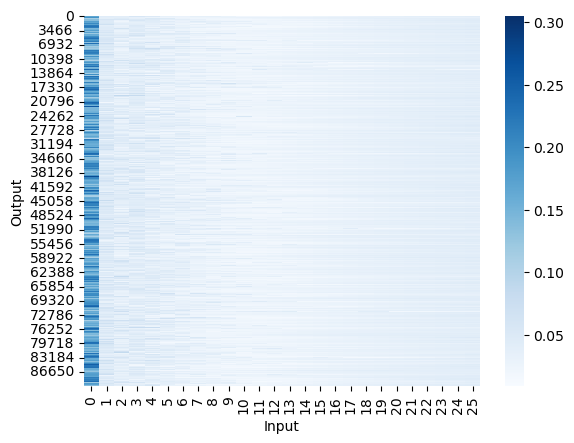

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Reshape the attention weights to 2D matrix
attention_weights_2d = attention_weights.reshape(4095*22, 26)

# Create a heatmap using seaborn
sns.heatmap(attention_weights_2d.detach().numpy(), cmap='Blues')

# Set labels for x-axis and y-axis
plt.xlabel("Input")
plt.ylabel("Output")

# Display the heatmap
plt.show()


In [119]:
def indices_to_words(input_data, int2char=int2char_hin):
    words = []
    for i in range(input_data.shape[0]):
        word=''
        for j in range(input_data.shape[1]):
            word=word+int2char[input_data[i,j].item()]
        words.append(word)
    words_until_eos= []
    for word in words:
        if '\n' in word:
            word = word.split('\n')[0]  # Extract the word until '\n'
        words_until_eos.append(word)

    return words_until_eos

In [120]:
dec_prd = indices_to_words(torch.argmax(dec_prd,axis=-1))

In [121]:
dec_prd

['थर्ममक्स',
 'सिखाएगा',
 'लीर्न',
 'ट्विटर्स',
 'तिरुनेववेली',
 'इंडेपेंडेंस',
 'स्पेषियों',
 'शुरूह',
 'कोलहपुर',
 'अझर',
 'करार',
 'अंका',
 'वीपीडीडी',
 'हाशी',
 'ग्लेंडले',
 'उमेड',
 'इक्ती',
 'आईडीएई',
 'अम्बिकापुर',
 'मैकरेे',
 'सबुदाने',
 'फूहद्ता',
 'सेक्यूंट',
 'शूब',
 'पानीहटी',
 'समेतती',
 'उखरुल',
 'ब्रह्मलिन',
 'उतराधिकारी',
 'इकबाल',
 'दयालापुरा',
 'सोहराई',
 'तकरीबन',
 'फर्ुखरनगर',
 'थेंगा',
 'ट्योहिरों',
 'कर्णेश्वरधाम',
 'उमनाथ',
 'दाँशिल',
 'साहित्तोस्व',
 'शंतिििकेतन',
 'शिकायतक्त्र',
 'अंदरखाने',
 'पैंटर',
 'लीदारों',
 'गालगंड',
 'कार्ियां',
 'मुर्गीपालन',
 'मुशाहिद',
 'मोडल्यूस',
 'राजौरी',
 'सुश्रुषा',
 'श्रींगर',
 'होल्ट',
 'लाइगिका',
 'इजाजत',
 'वाक्ष्ेत्र',
 'भूतल',
 'स्वादपरमिययों',
 'निनेटिज',
 'फ्रेक्टर',
 'लिखकर',
 'इयारकांदश्र',
 'नब्ज़',
 'क्वेस',
 'बौनी',
 'कारगुजरियां',
 'गौंगनम',
 'तपिया',
 'टेजपुर',
 'तलवे',
 'सीमाई',
 'दर्शनार्थी',
 'रिवास',
 'तर्कवाड',
 'अनुसाका',
 'कोचेल्ला',
 'लाकाकर',
 'पत्रवलियां',
 'परिषाद',
 'स्पिंज',
 'अंशिदा',
 'डिजेस',
 'सर

In [125]:
for i in range(len(df_test)):
    if len(df_test['English'][i])> 24:
        print(i)

2718


In [126]:
for i in range(len(df_test)):
    if len(df_test['transliteration_in_hindi'][i])>20:
        print(i)

In [127]:
df_test.drop(2717, inplace=True)
df_test.reset_index(drop=True, inplace=True)

In [128]:
df_test['predicted_words'] = dec_prd

In [129]:
df_test

,English,transliteration_in_hindi,predicted_words
0,thermax,थरमैक्स,थर्ममक्स
1,sikhaaega,सिखाएगा,सिखाएगा
2,learn,लर्न,लीर्न
3,twitters,ट्विटर्स,ट्विटर्स
4,tirunelveli,तिरुनेलवेली,तिरुनेववेली
...,...,...,...
4090,saflata,सफ़लता,सफलाता
4091,shbana,शबाना,श्बाना
4092,khaatootolaa,खातूटोला,खाटूटोला
4093,shivastava,शिवास्तव,शिवास्तवा


In [130]:
df_test.to_csv('test_predictions_attention.csv', index=False)